In [1]:
import sys
sys.path.append('../mast3r')
sys.path.append('../dust3r')

In [2]:
import cv2
import numpy as np

import torch
import torchvision.transforms.functional
# from matplotlib import pyplot as pl
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [3]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/home/user/javeda1/miniconda3/envs/mast3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda'
schedule = 'cosine'
lr = 0.01
niter = 300

In [5]:
img1_path = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png'
img2_path = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png'

In [6]:
model_name = "../naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

... loading model from ../naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [7]:
images = load_images([img1_path, img2_path], size=512)
output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

# at this stage, you have the raw dust3r predictions
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/user/javeda1/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [8]:
# find 2D-2D matches between the two images
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                               device=device, dist='dot', block_size=2**13)

In [9]:
# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
    matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
    matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

In [6]:
from mast3r.cloud_opt.sparse_ga import sparse_global_alignment, sparse_scene_optimizer
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs

/home/user/javeda1/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [53]:
img_paths = ['/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png', 
             '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png']

In [54]:
# Load images with predefined size
images = load_images(img_paths, size=512)

>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


In [56]:
scene_graph="swin-logwin-noncyclic"

In [57]:
pairs = make_pairs(img_paths, scene_graph=scene_graph, prefilter=None, symmetrize=True)

In [58]:
pairs

[('/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png',
  '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png'),
 ('/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png',
  '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png')]

In [59]:
#Create a dummy pair structure (as required by MASt3R)
# pairs = [[{'idx': 0, 'instance': img_paths[0]}, {'idx': 1, 'instance': img_paths[1]}]]
# pairs = [[{'idx': 0, 'instance': img_paths[0], 'true_shape':view1['true_shape'][0].numpy(), 'img': view1['img']},
#           {'idx': 1, 'instance': img_paths[1], 'true_shape':view2['true_shape'][0].numpy(), 'img': view2['img']}]]
# Define a cache path to store temporary files
cache_path = "./cache/"

In [60]:
pairs

[('/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png',
  '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png'),
 ('/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png',
  '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png')]

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [62]:
# Run pose estimation
sparse_gat = sparse_ga.sparse_global_alignment(img_paths, pairs, cache_path, model=model, device=device)

TypeError: string indices must be integers, not 'str'

In [23]:
view1.keys(), view2.keys()

(dict_keys(['img', 'true_shape', 'idx', 'instance']),
 dict_keys(['img', 'true_shape', 'idx', 'instance']))

In [33]:
view1['true_shape'][0].numpy()

array([160, 512], dtype=int32)

In [45]:
view1['img'].shape

torch.Size([1, 3, 160, 512])

In [50]:
view2['true_shape'][0].numpy()

array([160, 512], dtype=int32)

In [64]:
images

[{'img': tensor([[[[-0.8196, -0.7961, -0.8039,  ..., -0.4510, -0.6157, -0.3020],
            [-0.7882, -0.8039, -0.8118,  ..., -0.6078, -0.5294, -0.3882],
            [-0.7020, -0.7412, -0.8118,  ..., -0.4745, -0.6314, -0.6549],
            ...,
            [-0.7412, -0.7412, -0.7333,  ..., -0.7490, -0.6941, -0.6392],
            [-0.7333, -0.7176, -0.7020,  ..., -0.7804, -0.7569, -0.7098],
            [-0.7333, -0.7020, -0.7020,  ..., -0.7725, -0.7725, -0.7725]],
  
           [[-0.8039, -0.7804, -0.8039,  ..., -0.5608, -0.5765, -0.1059],
            [-0.7804, -0.7882, -0.8039,  ..., -0.6078, -0.5373, -0.3490],
            [-0.6549, -0.7098, -0.7882,  ..., -0.5294, -0.6314, -0.6784],
            ...,
            [-0.7255, -0.7255, -0.7255,  ..., -0.7647, -0.7020, -0.6627],
            [-0.7333, -0.7412, -0.7098,  ..., -0.7882, -0.7569, -0.7255],
            [-0.7490, -0.7255, -0.7020,  ..., -0.7804, -0.7882, -0.7725]],
  
           [[-0.8196, -0.8118, -0.8118,  ..., -0.5843, -0.5686,

In [68]:
# Load images (this returns a list of dictionaries)
images = load_images(img_paths, size=512)

# Extract only the file names (indices) from the loaded images
image_instances = [img_dict["instance"] for img_dict in images]

# Correct the pairs format (use extracted instances)
pairs = [[{'idx': 0, 'instance': image_instances[0]}, {'idx': 1, 'instance': image_instances[1]}]]

# Define cache path
cache_path = "./cache/"

# Run sparse alignment
sparse_ga = sparse_global_alignment(img_paths, pairs, cache_path, model=model, device="cuda")

>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


  0%|                                                                 | 0/1 [00:00<?, ?it/s]


KeyError: 'true_shape'

In [79]:
# Load images using MASt3R (returns a list of dicts)
images = load_images(img_paths, size=512)

# Ensure 'instance' values are correctly assigned
for i, img_dict in enumerate(images):
    img_dict["instance"] = str(i)  # Convert indices to string

# Correct the pairs format (reference loaded images)
pairs = [[{'idx': 0, 'instance': str(0), 'true_shape': images[0]["true_shape"], 'img': images[0]["img"]},
          {'idx': 1, 'instance': str(1), 'true_shape': images[1]["true_shape"], 'img': images[1]["img"]}]]

# Define cache path
cache_path = "./cache/"

# Run sparse alignment
sparse_ga = sparse_global_alignment(images, pairs, cache_path, model=model, device="cuda")


>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


  0%|                                                                 | 0/1 [00:00<?, ?it/s]


AttributeError: 'dict' object has no attribute 'encode'

In [73]:
images[0]['instance']

'0'

In [74]:
images[1]["instance"]

'1'

In [7]:
# Load the MASt3R model
model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

# Load images (size=512 as per the demo code)
img_paths = [img1_path, img2_path]
images = load_images(img_paths, size=512)

# Perform inference with MASt3R
output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

# Extract descriptors
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']
desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

# Find 2D-2D matches
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8, device=device, dist='dot', block_size=2**13)


# Filter out matches near the border
H0, W0 = view1['true_shape'][0].cpu().numpy()
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < W0 - 3) & \
                    (matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < H0 - 3)

H1, W1 = view2['true_shape'][0].cpu().numpy()
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < W1 - 3) & \
                    (matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < H1 - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

# Convert to numpy
pts1 = matches_im0
pts2 = matches_im1

>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/user/javeda1/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [8]:
# Estimate the Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

# Compute the Essential Matrix (E = K^T * F * K) assuming identity intrinsics initially
E = F  # Placeholder since K is unknown

# Decompose Essential Matrix into Rotation (R) and Translation (t)
_, R, t, mask = cv2.recoverPose(E, pts1, pts2)

In [9]:
from mast3r.cloud_opt.sparse_ga import sparse_global_alignment
from mast3r.cloud_opt.sparse_ga import estimate_focal_knowing_depth

In [10]:
# Estimate intrinsics using focal estimation from MASt3R
focal_length = estimate_focal_knowing_depth(pred1['pts3d'], torch.tensor([W0//2, H0//2]), focal_mode='weiszfeld', min_focal=0.5, max_focal=3.5)


In [13]:
focal_length

tensor([328.1482])

In [14]:
# Construct intrinsics matrix
K = np.array([[focal_length.item(), 0, W0 / 2],
              [0, focal_length.item(), H0 / 2],
              [0, 0, 1]])


In [16]:
K

array([[328.14819336,   0.        , 256.        ],
       [  0.        , 328.14819336,  80.        ],
       [  0.        ,   0.        ,   1.        ]])

In [17]:
det_R = np.linalg.det(R)
print(f"Determinant of R: {det_R:.6f}")

# Check if determinant is close to 1
if np.isclose(det_R, 1.0, atol=1e-3):
    print("✅ Rotation matrix is valid.")
else:
    print("❌ Rotation matrix is incorrect.")

Determinant of R: 1.000000
✅ Rotation matrix is valid.


In [18]:
identity_check = np.dot(R.T, R)
print("R^T * R:\n", identity_check)

# Should be approximately identity
if np.allclose(identity_check, np.eye(3), atol=1e-3):
    print("✅ Rotation matrix is orthogonal.")
else:
    print("❌ Rotation matrix is NOT orthogonal.")

R^T * R:
 [[1.00000000e+00 6.75303830e-17 3.40583870e-17]
 [6.75303830e-17 1.00000000e+00 1.37728749e-16]
 [3.40583870e-17 1.37728749e-16 1.00000000e+00]]
✅ Rotation matrix is orthogonal.


In [51]:
pred1['pts3d']

tensor([[[[-4.6560, -1.6313,  6.1651],
          [-4.7368, -1.5960,  6.2805],
          [-4.7546, -1.5850,  6.2783],
          ...,
          [ 6.0499, -1.9674,  7.8425],
          [ 6.0839, -1.9082,  7.9113],
          [ 5.7948, -1.9525,  7.8119]],

         [[-4.7806, -1.5154,  6.2324],
          [-4.7632, -1.5468,  6.1565],
          [-4.7062, -1.5447,  6.1388],
          ...,
          [ 6.1351, -1.9407,  7.9027],
          [ 6.0866, -1.9025,  7.8506],
          [ 5.8875, -1.9659,  7.7137]],

         [[-4.7427, -1.5387,  6.1607],
          [-4.7812, -1.5170,  6.2080],
          [-4.7527, -1.4726,  6.1892],
          ...,
          [ 6.0998, -1.8566,  7.9473],
          [ 6.0162, -1.8542,  7.7892],
          [ 5.9794, -1.8607,  7.7241]],

         ...,

         [[-2.3890,  0.7261,  3.0225],
          [-2.3641,  0.7110,  2.9943],
          [-2.3685,  0.7074,  3.0107],
          ...,
          [ 2.0810,  0.6222,  2.6534],
          [ 2.0945,  0.6235,  2.6758],
          [ 2.0764,  0

In [20]:
pred1['pts3d'].shape

torch.Size([1, 160, 512, 3])

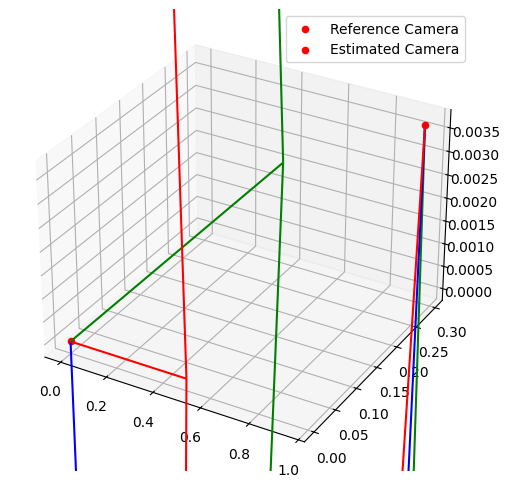

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_camera(ax, R, t, scale=1.0, label="Camera"):
    """Plot camera center and axes in 3D space"""
    cam_center = -R.T @ t  # Convert from camera-to-world

    ax.scatter(*cam_center, marker='o', label=label, color='red')
    ax.quiver(*cam_center, *R[:, 0], length=scale, color='r')
    ax.quiver(*cam_center, *R[:, 1], length=scale, color='g')
    ax.quiver(*cam_center, *R[:, 2], length=scale, color='b')

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot camera at origin
plot_camera(ax, np.eye(3), np.zeros((3, 1)), scale=0.5, label="Reference Camera")

# Plot estimated camera
plot_camera(ax, R, t, scale=0.5, label="Estimated Camera")

ax.legend()
plt.show()

In [21]:
def project_3d_to_2d(K, R, t, points_3d):
    """
    Projects 3D points onto the image plane using the given intrinsics (K), rotation (R), and translation (t).
    """
    # Convert points to homogeneous coordinates
    points_3d_hom = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))  # (N, 4)

    # Construct extrinsics matrix [R | t]
    Rt = np.hstack((R, t))  # (3, 4)

    # Project 3D points
    projected_points_hom = K @ Rt @ points_3d_hom.T  # (3, N)

    # Convert homogeneous coordinates to 2D
    projected_points = projected_points_hom[:2, :] / projected_points_hom[2, :]  # Normalize by depth

    return projected_points.T  # (N, 2)

# Generate some sample 3D points (assuming they are in front of the camera)
sample_3d_points = pred1['pts3d'].squeeze(0).reshape(-1,3)

# Project points
projected_2d_points = project_3d_to_2d(K, R, t, sample_3d_points)

print("Projected 2D points:\n", projected_2d_points)

Projected 2D points:
 [[-343.55588728  310.21825251]
 [-348.32954818  317.16400628]
 [-351.77976221  318.28555927]
 ...
 [ 348.17187176  554.56136883]
 [ 351.1167877   562.60484445]
 [ 350.01060341  563.59981318]]


In [22]:
from mast3r.cloud_opt.sparse_ga import sparse_global_alignment

In [9]:
# Prepare image pairs
pairs = [[{'idx': 0, 'instance': "0"}, {'idx': 1, 'instance': "1"}]]

# Run sparse_global_alignment to get optimized intrinsics & extrinsics
scene = sparse_global_alignment(img_paths, pairs, cache_path="./cache/", model=model, device=device)

# Extract intrinsics (K)
intrinsics = scene.get_focals()
principal_points = scene.get_principal_points()
K = torch.tensor([[intrinsics[0], 0, principal_points[0][0]],
                  [0, intrinsics[0], principal_points[0][1]],
                  [0, 0, 1]])

# Extract optimized extrinsics (camera poses)
poses = scene.get_im_poses()  # 4x4 camera extrinsic matrices

# Get R and t for each image
R1, t1 = poses[0][:3, :3], poses[0][:3, 3]
R2, t2 = poses[1][:3, :3], poses[1][:3, 3]

print("Intrinsic Matrix K:\n", K.numpy())
print("\nCamera 1 Pose (R, t):\n", R1.numpy(), "\n", t1.numpy())
print("\nCamera 2 Pose (R, t):\n", R2.numpy(), "\n", t2.numpy())


  0%|                                                                 | 0/1 [00:00<?, ?it/s]


KeyError: 'true_shape'

In [12]:
view1.keys()

dict_keys(['img', 'true_shape', 'idx', 'instance'])

In [15]:
# Ensure `idx` values are integers
idx1 = int(view1["idx"]) if isinstance(view1["idx"], (list, torch.Tensor)) else view1["idx"]
idx2 = int(view2["idx"]) if isinstance(view2["idx"], (list, torch.Tensor)) else view2["idx"]

# Properly structure `imgs` (list, not dict)
imgs = [view1, view2]

# Construct pairs using corrected `idx`
pairs = [[{'idx': idx1, 'instance': view1["instance"]},
          {'idx': idx2, 'instance': view2["instance"]}]]

# Run sparse_global_alignment
scene = sparse_global_alignment(imgs, pairs, cache_path="./cache/", model=model, device=device)

# Extract intrinsics (K)
intrinsics = scene.get_focals()
principal_points = scene.get_principal_points()
K = torch.tensor([[intrinsics[0], 0, principal_points[0][0]],
                  [0, intrinsics[0], principal_points[0][1]],
                  [0, 0, 1]])

# Extract optimized extrinsics (camera poses)
poses = scene.get_im_poses()  # 4x4 camera extrinsic matrices

# Get R and t for each image
R1, t1 = poses[0][:3, :3], poses[0][:3, 3]
R2, t2 = poses[1][:3, :3], poses[1][:3, 3]

print("Intrinsic Matrix K:\n", K.numpy())
print("\nCamera 1 Pose (R, t):\n", R1.numpy(), "\n", t1.numpy())
print("\nCamera 2 Pose (R, t):\n", R2.numpy(), "\n", t2.numpy())

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [24]:
from dust3r.image_pairs import make_pairs
import os

In [25]:
# Define file paths
filelist = [img1_path, img2_path]  # Your input image files
image_size = 512
scenegraph_type = "complete"  # Graph structure type
optim_level = "coarse"  # Optimization level
shared_intrinsics = True  # Assume cameras share intrinsics
gradio_delete_cache = False  # Flag for cache cleanup
outdir = "./cache_output"  # Cache directory

# Load images
imgs = load_images(filelist, size=image_size, verbose=True)

# If only one image is provided, duplicate it for processing
if len(imgs) == 1:
    imgs = [imgs[0], copy.deepcopy(imgs[0])]
    imgs[1]['idx'] = 1
    filelist = [filelist[0], filelist[0] + '_2']

# Generate scene graph-based pairs
scene_graph_params = [scenegraph_type]
scene_graph = '-'.join(scene_graph_params)
pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True)

# Configure cache directory
if gradio_delete_cache:
    cache_dir = tempfile.mkdtemp(suffix='_cache', dir=outdir)
else:
    cache_dir = os.path.join(outdir, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# Run sparse_global_alignment
scene = sparse_global_alignment(filelist, pairs, cache_dir,
                                model, lr1=0.2, niter1=1000, lr2=0.02, niter2=10, device=device,
                                opt_depth='depth' in optim_level, shared_intrinsics=shared_intrinsics,
                                matching_conf_thr=5.0)

# Extract intrinsics (K)
intrinsics = scene.get_focals()
principal_points = scene.get_principal_points()
K = torch.tensor([[intrinsics[0], 0, principal_points[0][0]],
                  [0, intrinsics[0], principal_points[0][1]],
                  [0, 0, 1]])

# Extract optimized extrinsics (camera poses)
poses = scene.get_im_poses()  # 4x4 camera extrinsic matrices

# Get R and t for each image
R1, t1 = poses[0][:3, :3], poses[0][:3, 3]
R2, t2 = poses[1][:3, :3], poses[1][:3, 3]

print("Intrinsic Matrix K:\n", K.numpy())
print("\nCamera 1 Pose (R, t):\n", R1.detach().cpu().numpy(), "\n", t1.detach().cpu().numpy())
print("\nCamera 2 Pose (R, t):\n", R2.detach().cpu().numpy(), "\n", t2.detach().cpu().numpy())


>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


100%|█████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.85it/s]
/home/user/javeda1/miniconda3/envs/mast3r/lib/python3.11/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


init focal (shared) =  312.74


100%|████████████████████████████| 1000/1000 [00:10<00:00, 98.86it/s, lr=0.0000, loss=1.256]


>> final loss = 1.2560713291168213


100%|████████████████████████████████| 10/10 [00:00<00:00, 77.69it/s, lr=0.0005, loss=1.004]


>> final loss = 1.0042130947113037
Final focal (shared) =  313.42
Intrinsic Matrix K:
 [[313.4181    0.      276.21188]
 [  0.      313.4181   78.68963]
 [  0.        0.        1.     ]]

Camera 1 Pose (R, t):
 [[-0.15303323  0.96415716  0.21675348]
 [-0.60729283 -0.26478705  0.74905515]
 [ 0.77960026 -0.01700255  0.6260469 ]] 
 [-1.7470148 -6.1702704 -4.5843334]

Camera 2 Pose (R, t):
 [[-0.16185737  0.9636845   0.2124022 ]
 [-0.6155553  -0.26682878  0.74154884]
 [ 0.771294   -0.01072019  0.63638926]] 
 [-1.3161229 -4.6319385 -3.2871423]


In [23]:
a = scene.depthmaps[0].reshape(-1, 512).detach().cpu().numpy()
plt.figure(figsize=(10, 5))
plt.imshow(a, cmap='jet')  # Use 'jet' for colored depth visualization
plt.colorbar(label="Depth (Z-coordinate)")
# plt.title(title)
plt.axis("off")
plt.show()

RuntimeError: shape '[-1, 512]' is invalid for input of size 1280

In [38]:
# Run sparse_global_alignment
scene = sparse_global_alignment(filelist, pairs, cache_dir,
                                model, lr1=0.2, niter1=1000, lr2=0.02, niter2=1000, device=device,
                                opt_depth='depth' in optim_level, shared_intrinsics=shared_intrinsics,
                                matching_conf_thr=5.0, subsample=1)

# Extract intrinsics (K)
intrinsics = scene.get_focals()
principal_points = scene.get_principal_points()
K = torch.tensor([[intrinsics[0], 0, principal_points[0][0]],
                  [0, intrinsics[0], principal_points[0][1]],
                  [0, 0, 1]])

# Extract optimized extrinsics (camera poses)
poses = scene.get_im_poses()  # 4x4 camera extrinsic matrices

# Get R and t for each image
R1, t1 = poses[0][:3, :3], poses[0][:3, 3]
R2, t2 = poses[1][:3, :3], poses[1][:3, 3]

print("Intrinsic Matrix K:\n", K.numpy())
print("\nCamera 1 Pose (R, t):\n", R1.detach().cpu().numpy(), "\n", t1.detach().cpu().numpy())
print("\nCamera 2 Pose (R, t):\n", R2.detach().cpu().numpy(), "\n", t2.detach().cpu().numpy())


100%|████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.91it/s]


init focal (shared) =  312.74


100%|███████████████████████████| 1000/1000 [00:09<00:00, 102.91it/s, lr=0.0000, loss=1.270]


>> final loss = 1.269518256187439


100%|████████████████████████████| 1000/1000 [00:13<00:00, 75.28it/s, lr=0.0000, loss=0.484]


>> final loss = 0.4844273626804352
Final focal (shared) =  293.34
Intrinsic Matrix K:
 [[293.337     0.      229.84373]
 [  0.      293.337    73.10455]
 [  0.        0.        1.     ]]

Camera 1 Pose (R, t):
 [[-0.44930252 -0.8729732  -0.1898556 ]
 [-0.80511785  0.3035622   0.50954425]
 [-0.38718548  0.38179564 -0.8392375 ]] 
 [ 2.5418155 -3.2966204  6.5199504]

Camera 2 Pose (R, t):
 [[-0.44504863 -0.87331    -0.1981456 ]
 [-0.8132079   0.30147353  0.49780208]
 [-0.37499982  0.38267967 -0.84435284]] 
 [ 2.0373776 -2.4854238  4.752824 ]


In [39]:
cam2w = torch.eye(4)  # Initialize Identity Matrix
cam2w[:3, :3] = R1  # Set Rotation
cam2w[:3, 3] = t1.squeeze()  # Set Translation

print("Camera-to-World Transformation Matrix (cam2w):\n", cam2w)

Camera-to-World Transformation Matrix (cam2w):
 tensor([[-0.4493, -0.8730, -0.1899,  2.5418],
        [-0.8051,  0.3036,  0.5095, -3.2966],
        [-0.3872,  0.3818, -0.8392,  6.5200],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [28]:
K
K = K.unsqueeze(0)  # Shape becomes [1, 3, 3]

In [29]:
cam2w.device

device(type='cpu')

In [32]:
H, W = 160, 512
# anchors = torch.rand((H, W, 2))  # Example 2D keypoints (random for demonstration)

In [44]:
depthmaps = scene.depthmaps[0]

In [45]:
depthmaps = depthmaps.to('cpu')
depthmaps.device

device(type='cpu')

In [36]:
from mast3r.cloud_opt.sparse_ga import make_pts3d

In [37]:
from mast3r.cloud_opt.sparse_ga import make_pts3d, anchor_depth_offsets

In [38]:
subsample = 8
# Compute Pixels for Anchors
pixels = torch.from_numpy(np.mgrid[:W, :H].T.reshape(-1, 2)).float().to('cpu')

# Compute Anchor Depth Offsets
idxs, offsets = anchor_depth_offsets(depthmaps, {0: (pixels, None)}, subsample=subsample)


In [40]:
K.device, cam2w.device, depthmaps.device

(device(type='cpu'), device(type='cpu'), device(type='cpu'))

In [41]:
# Format Anchors Correctly
anchors = {0: (pixels, idxs[0], offsets[0])}

In [46]:


# Convert Depth to 3D Points
pts3d_world, depth_out = make_pts3d(anchors, K, cam2w, depthmaps, ret_depth=True)

IndexError: too many indices for tensor of dimension 0

In [66]:
# Convert 2D points + depth into 3D world coordinates
pts3d_world = make_pts3d(anchors, K, cam2w, depthmaps, ret_depth=True)

AttributeError: 'Tensor' object has no attribute 'items'

In [69]:
scene.anchors()

AttributeError: 'SparseGA' object has no attribute 'anchors'

In [34]:
R1.shape, t1.shape

(torch.Size([3, 3]), torch.Size([3]))

In [30]:
from mpl_toolkits.mplot3d import Axes3D

def plot_camera(ax, R, t, scale=0.5, label="Camera"):
    """
    Plots a camera pose in 3D space using rotation (R) and translation (t).
    """
    # Compute camera center in world coordinates
    cam_center = -R.T @ t  # Convert from camera-to-world

    # Plot camera position
    ax.scatter(*cam_center, marker='o', label=label, color='red')

    # Draw camera axes (RGB: XYZ)
    axes = np.eye(3) * scale  # Scaled unit vectors
    transformed_axes = R.T @ axes  # Apply rotation to axes

    for i, color in enumerate(['r', 'g', 'b']):  # X = Red, Y = Green, Z = Blue
        ax.quiver(*cam_center, *transformed_axes[:, i], length=scale, color=color)

    return cam_center


In [40]:
t1_temp = t1.reshape(3, 1)

In [41]:
t1_temp = t1_temp.detach().cpu().numpy()

In [42]:
R1_temp =  R1.detach().cpu().numpy()

In [43]:
R1_temp

array([[-0.44930252, -0.8729732 , -0.1898556 ],
       [-0.80511785,  0.3035622 ,  0.50954425],
       [-0.38718548,  0.38179564, -0.8392375 ]], dtype=float32)

In [ ]:
R2, t2

In [35]:
R2 = np.eye(3)  # Example second camera as identity rotation
t2 = np.array([0, 0, 0]).reshape(3, 1)  # Origin

In [44]:
R2_temp = R2.detach().cpu().numpy()
t2_temp = t2.detach().cpu().numpy()

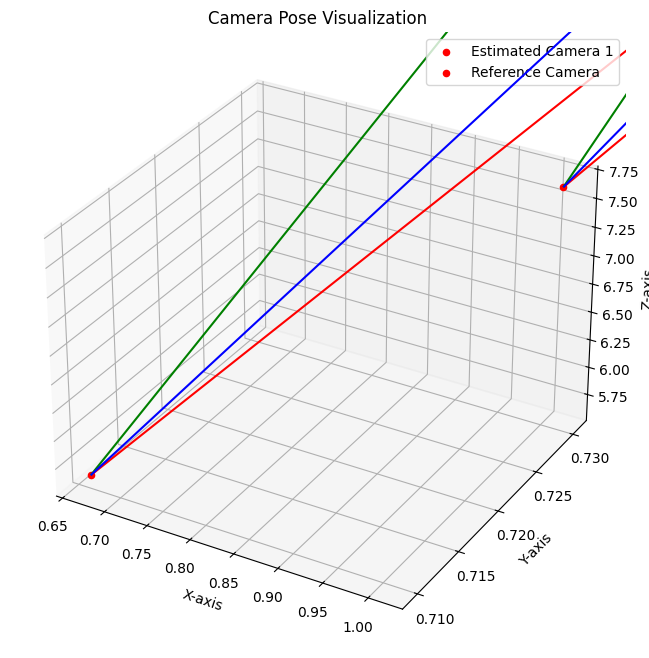

In [47]:
# Plot the Camera Positions and Orientations
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Camera 1 and Camera 2
c1 = plot_camera(ax, R1_temp, t1_temp, scale=1, label="Estimated Camera 1")
c2 = plot_camera(ax, R2_temp, t2_temp, scale=1, label="Reference Camera")

# Configure the 3D Plot
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Camera Pose Visualization")
ax.legend()
plt.show()

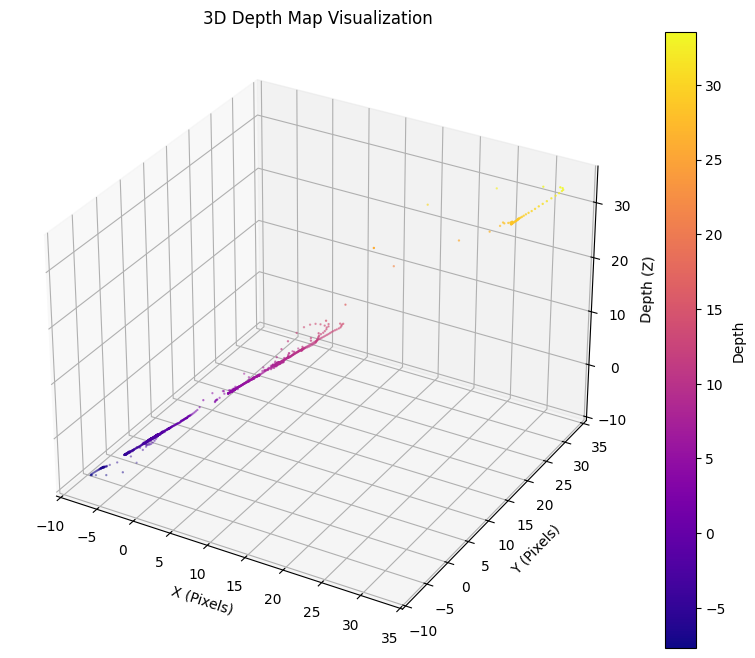

In [49]:
pts3d_np = pred1['pts3d'].detach().cpu().numpy()

# Extract X, Y, and Depth (Z)
x_vals, y_vals, z_vals = pts3d_np[:, 0], pts3d_np[:, 1], pts3d_np[:, 2]

# Plot 3D Depth Map
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x_vals, y_vals, z_vals, c=z_vals, cmap='plasma', s=0.5)
plt.colorbar(sc, label="Depth")
ax.set_xlabel("X (Pixels)")
ax.set_ylabel("Y (Pixels)")
ax.set_zlabel("Depth (Z)")
ax.set_title("3D Depth Map Visualization")
plt.show()

In [48]:
pred1

{'pts3d': tensor([[[[-4.6560, -1.6313,  6.1651],
           [-4.7368, -1.5960,  6.2805],
           [-4.7546, -1.5850,  6.2783],
           ...,
           [ 6.0499, -1.9674,  7.8425],
           [ 6.0839, -1.9082,  7.9113],
           [ 5.7948, -1.9525,  7.8119]],
 
          [[-4.7806, -1.5154,  6.2324],
           [-4.7632, -1.5468,  6.1565],
           [-4.7062, -1.5447,  6.1388],
           ...,
           [ 6.1351, -1.9407,  7.9027],
           [ 6.0866, -1.9025,  7.8506],
           [ 5.8875, -1.9659,  7.7137]],
 
          [[-4.7427, -1.5387,  6.1607],
           [-4.7812, -1.5170,  6.2080],
           [-4.7527, -1.4726,  6.1892],
           ...,
           [ 6.0998, -1.8566,  7.9473],
           [ 6.0162, -1.8542,  7.7892],
           [ 5.9794, -1.8607,  7.7241]],
 
          ...,
 
          [[-2.3890,  0.7261,  3.0225],
           [-2.3641,  0.7110,  2.9943],
           [-2.3685,  0.7074,  3.0107],
           ...,
           [ 2.0810,  0.6222,  2.6534],
           [ 2.0945, 

In [53]:
scene.get_sparse_pts3d()[0].shape

torch.Size([50324, 3])

In [54]:
scene.get_dense_pts3d()

([tensor([[ 4.5499,  2.3336,  3.1833],
          [ 4.5418,  2.3191,  3.1763],
          [ 4.5337,  2.3045,  3.1693],
          ...,
          [-8.2995, -5.3798, -7.0885],
          [-8.3185, -5.4139, -7.1049],
          [-8.3375, -5.4480, -7.1213]], device='cuda:0'),
  tensor([[ 4.2238,  3.8079,  0.9176],
          [ 4.2148,  3.7915,  0.9100],
          [ 4.2058,  3.7750,  0.9024],
          ...,
          [-8.5100, -4.7432, -8.3401],
          [-8.5282, -4.7765, -8.3555],
          [-8.5464, -4.8098, -8.3709]], device='cuda:0')],
 [tensor([ 5.2878,  5.2878,  5.2878,  ..., 12.4175, 12.4175, 12.4175],
         device='cuda:0'),
  tensor([ 5.9379,  5.9379,  5.9379,  ..., 12.0211, 12.0211, 12.0211],
         device='cuda:0')],
 [tensor([[0.2337, 0.2560, 0.2333,  ..., 0.0823, 0.0535, 0.0556],
          [0.2888, 0.3851, 0.6134,  ..., 0.2199, 0.1112, 0.0649],
          [0.4074, 0.4154, 0.5187,  ..., 0.2006, 0.1780, 0.1161],
          ...,
          [4.4261, 3.8870, 4.0330,  ..., 5.4885, 5.52

In [57]:
scene.show()